In [1]:

import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
import re
import emoji

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
!pip install sklearn_crfsuite
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
!pip install fastai
!pip install emoji

  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Created wheel for pythainlp: filename=pythainlp-2.2.dev0-cp37-none-any.whl size=12568254 sha256=fff3bbf6d398f74dbd03b7feead2ebc5830f24f6d4084cef43b856c02a7038e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1n4bkmup/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
Successfully built pythainlp


In [3]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#fastai
import fastai
from fastai.text import *
from fastai.callbacks import CSVLogger

#pythainlp
from pythainlp.ulmfit import *

In [4]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in word_tokenize(res, engine='ulmfit') if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

In [5]:
df = pd.read_excel('comment_1000perOneClass_quoteV2.xlsx')

In [6]:
df1 = df.iloc[:5470,:]

In [7]:
df1.describe()

,comment_post_id,comment_id,comment_picture,comment_video,comment_u_time,top_fan,comment_reply_count,parent_comment,reply_comment_id,reply_comment_author_id,reply_comment_top_fan,reply_comment_pic,reply_comment_vid,reply_comment_reaction_count,reply_u_time,rude,offensive,figurative,dirty
count,5.470000e+03,5.470000e+03,5470.000000,5470.000000,5.470000e+03,5470.000000,5470.000000,7.370000e+02,7.370000e+02,7.370000e+02,737.000000,737.000000,737.0,737.000000,7.370000e+02,5470.000000,5469.000000,5470.000000,5470.000000
mean,1.868730e+15,1.806821e+15,0.035283,0.000548,1.550721e+09,0.210786,0.158318,1.787571e+15,1.761618e+15,8.416359e+14,0.130258,0.016282,0.0,2.812754,1.549326e+09,0.701645,0.101481,0.205302,0.011883
std,5.745790e+14,4.293388e+14,0.184512,0.023415,2.139592e+07,0.407904,1.960615,4.137728e+14,4.575410e+14,8.865192e+14,0.336815,0.126645,0.0,8.429709,2.047070e+07,0.457578,0.301992,0.403959,0.108369
min,1.083968e+14,1.001940e+14,0.000000,0.000000,1.401444e+09,0.000000,0.000000,1.132041e+14,1.041302e+14,5.329571e+08,0.000000,0.000000,0.0,0.000000,1.436890e+09,0.000000,0.000000,0.000000,0.000000
25%,1.636257e+15,1.622646e+15,0.000000,0.000000,1.539754e+09,0.000000,0.000000,1.619361e+15,1.601602e+15,1.000018e+14,0.000000,0.000000,0.0,0.000000,1.538973e+09,0.000000,0.000000,0.000000,0.000000
50%,1.880022e+15,1.873567e+15,0.000000,0.000000,1.555135e+09,0.000000,0.000000,1.827692e+15,1.827856e+15,1.000218e+14,0.000000,0.000000,0.0,1.000000,1.552287e+09,1.000000,0.000000,0.000000,0.000000
75%,2.117763e+15,2.118491e+15,0.000000,0.000000,1.566616e+09,0.000000,0.000000,2.098684e+15,2.099350e+15,1.792046e+15,0.000000,0.000000,0.0,2.000000,1.565593e+09,1.000000,0.000000,0.000000,0.000000
max,1.020190e+16,2.538749e+15,1.000000,1.000000,1.576811e+09,1.000000,58.000000,2.357923e+15,2.340533e+15,3.032810e+15,1.000000,1.000000,0.0,123.000000,1.576666e+09,1.000000,1.000000,1.000000,1.000000


In [8]:
# df2 = df1[['comment_text','rude', 'offensive', 'figurative', 'dirty']]
df2 = df1[['comment_text','rude']]

In [9]:
df2.dropna(inplace=True)

/home/posoma/miniconda3/envs/posoma/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
abuss_type = 'rude'

In [11]:
df2[abuss_type] = pd.to_numeric(df2[abuss_type], downcast='integer')

/home/posoma/miniconda3/envs/posoma/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df2.columns = ['texts', 'category']

import numpy as np
from sklearn.model_selection import train_test_split

all_df, test_df = train_test_split(df2, train_size = 0.7, shuffle = True)

all_df['processed'] = all_df.texts.map(lambda x: '|'.join(process_text(x)))
all_df['wc'] = all_df.processed.map(lambda x: len(x.split('|')))
all_df['uwc'] = all_df.processed.map(lambda x: len(set(x.split('|'))))

test_df['processed'] = test_df.texts.map(lambda x: '|'.join(process_text(x)))
test_df['wc'] = test_df.processed.map(lambda x: len(x.split('|')))
test_df['uwc'] = test_df.processed.map(lambda x: len(set(x.split('|'))))

In [16]:
all_df.category.value_counts() / all_df.shape[0]

1    0.701933
0    0.298067
Name: category, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [18]:
print(train_df['category'].value_counts() / train_df.shape[0])
print(valid_df['category'].value_counts() / valid_df.shape[0])

1    0.703966
0    0.296034
Name: category, dtype: float64
1    0.690435
0    0.309565
Name: category, dtype: float64


In [19]:
y_train = train_df['category']
y_valid = valid_df['category']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df['texts'])
text_train = tfidf_fit.transform(train_df['texts'])
text_valid = tfidf_fit.transform(valid_df['texts'])
text_test = tfidf_fit.transform(test_df['texts'])
text_train.shape, text_valid.shape

/home/posoma/miniconda3/envs/posoma/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((3253, 578), (575, 578))

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[['wc','uwc']].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[['wc','uwc']].astype(float))
num_valid = scaler_fit.transform(valid_df[['wc','uwc']].astype(float))
num_test = scaler_fit.transform(test_df[['wc','uwc']].astype(float))
num_train.shape, num_valid.shape

[18.312173 16.183124] [267.976477 166.467249]


((3253, 2), (575, 2))

In [22]:
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((3253, 580), (575, 580))

In [23]:
model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.8730434782608696

In [24]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df['preds'] = model.predict(X_valid)
probs_df['category'] = valid_df.category
probs_df['texts'] = valid_df.texts
probs_df['processed'] = valid_df.processed
probs_df['wc'] = valid_df.wc
probs_df['uwc'] = valid_df.uwc
probs_df['hit'] = (probs_df.preds==probs_df.category)
probs_df.to_csv('probs_df_linear.csv',index=False)

0.8730434782608696


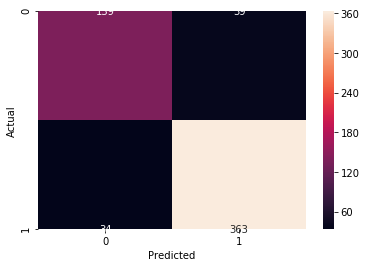

In [25]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
test_df['category'] = model.predict(X_test)
all_aug = pd.concat([test_df,all_df]).reset_index(drop=True)
print(all_aug.shape)
# all_aug.to_csv('all_aug.csv',index=False)

(5470, 5)


/home/posoma/miniconda3/envs/posoma/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# ULMFIT

In [29]:
# import pandas as pd
# import numpy as np
# from ast import literal_eval
# from tqdm import tqdm_notebook
# from collections import Counter
# import re

# #viz
# import matplotlib.pyplot as plt
# import seaborn as sns

# #fastai
# import fastai
# from fastai.text import *
# from fastai.callbacks import CSVLogger

# #pythainlp
# from pythainlp.ulmfit import *
model_path = 'wisesight_data/'

In [30]:
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)

In [31]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols='texts', processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()

/home/posoma/miniconda3/envs/posoma/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [32]:
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(3790, 38)

In [33]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

RuntimeError: unexpected EOF, expected 20330968 more bytes. The file might be corrupted.

In [34]:
torch.__version__

'1.3.1'

In [35]:
!conda info -e

# conda environments:
#
base                     /home/posoma/miniconda3
posoma                *  /home/posoma/miniconda3/envs/posoma

